# Finite Time Lyapunov Exponent (FTLE)
In this example, we will compute the Finite Time Laypunov Exponent (FTLE) field for a co-rotating vortex pair. 

In [1]:
using ViscousFlow

In [2]:
using ILMPostProcessing

Precompiling ILMPostProcessing
  ✓ ILMPostProcessing
  1 dependency successfully precompiled in 3 seconds. 219 already precompiled.


In [3]:
using Plots

## Setup the Co-rotating Vortices Problem
The grid Re number is chosen at 10.0 to speed up computations.

In [4]:
my_params = Dict()
my_params["Re"] = 400
xlim = (-3.0,3.0)
ylim = (-3.0,3.0)
my_params["grid Re"] = 10.0

10.0

In [5]:
g = setup_grid(xlim,ylim,my_params)

PhysicalGrid{2}((242, 250), (121, 125), 0.025, ((-3.0, 3.0), (-3.1, 3.1)), 12)

In [6]:
sys = viscousflow_system(g,phys_params=my_params);

In [7]:
σ = 0.1
x01, y01 = 1.0, 0.0
x02, y02 = -1.0, 0.0
A = 3
twogauss = SpatialGaussian(σ,σ,x01,y01,A) + SpatialGaussian(σ,σ,x02,y02,A)

AddedFields:
  SpatialGaussian{false, 0}([0.010000000000000002 0.0; 0.0 0.010000000000000002], [99.99999999999999 -0.0; -0.0 99.99999999999999], [1.0, 0.0], 3.0, 47.7464829275686, [0.0, 0.0])
  SpatialGaussian{false, 0}([0.010000000000000002 0.0; 0.0 0.010000000000000002], [99.99999999999999 -0.0; -0.0 99.99999999999999], [-1.0, 0.0], 3.0, 47.7464829275686, [0.0, 0.0])


In [8]:
u0 = init_sol(twogauss,sys)

(Dual nodes in a (nx = 242, ny = 250) cell grid of type Float64 data
  Number of Dual nodes: (nx = 242, ny = 250), Float64[])

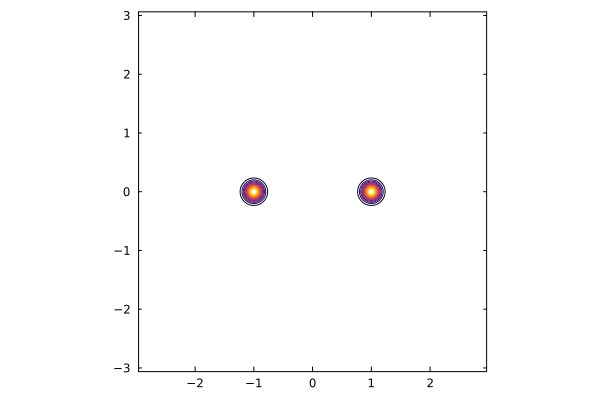

In [9]:
plot(vorticity(u0,sys,0.0),sys)

## Solve the Problem
Step the integrator repeatedly until the solution is generated for t = (0.0, 20.0).

In [10]:
T = 1.0
tspan = (0.0,T)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 242, ny = 250) cell grid of type Float64 data
  Number of Dual nodes: (nx = 242, ny = 250), Float64[])

In [11]:
T = 20.0
@time begin
    step!(integrator,T)
end

 31.632961 seconds (9.26 M allocations: 23.733 GiB, 0.88% gc time, 3.28% compilation time)


In [12]:
sol = integrator.sol;

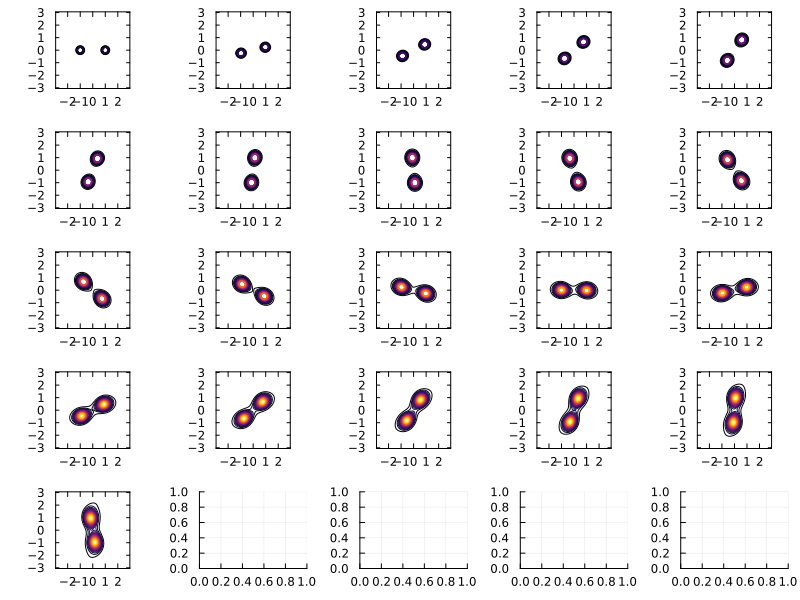

In [13]:
plt = plot(layout = (5,5), size = (800, 600), legend=:false)
tsnap = 0.0:1.0:20.0
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,levels=range(0.1,5,length=31))
end
savefig(plt,"CoRotating.pdf")
plt

## Discretize the Solution in Time
This step stores the velocity fields as interpolatable fields at chosen time steps so that the velocity fields don't need to be computed every iteration the IVP is solved.

In [14]:
u = []
v = []
t_start = 0.0
t_end = 20.0
dt = 0.01
time = t_start:dt:t_end

@time for t in time
    push!(u, interpolatable_field(velocity(sol, sys, t).u, g))
    push!(v, interpolatable_field(velocity(sol, sys, t).v, g))
end

 13.499413 seconds (3.45 M allocations: 20.339 GiB, 15.51% gc time, 3.75% compilation time)


## Generate Initial Conditions

In [15]:
MARGIN = 0.0
X_MIN = -2.0
X_MAX = 2.0
Y_MIN = -2.0
Y_MAX = 2.0

nx, ny = 500, 500  # example grid size
x0 = range(X_MIN - MARGIN, X_MAX + MARGIN, length=nx)
y0 = range(Y_MIN - MARGIN, Y_MAX + MARGIN, length=ny)
dx = x0[2] - x0[1]
dy = y0[2] - y0[1]

# Define the initial conditions as a standard matrix
initial_conditions_matrix = [ [x0[i], y0[j]] for i in 1:nx, j in 1:ny]
initial_conditions_matrix = initial_conditions_matrix'

# Flatten the initial conditions matrix into a 1D array
initial_conditions = vcat(initial_conditions_matrix...);

## Solve the IVP and Generate FTLE Fields

### Computing the FTLE Field at One Time Snapshot

In [ ]:
FTLE = zeros(Float64, ny - 2, nx - 2)
T = 6.0

# Generate the GIF
@time @gif for t0 in 6.0:0.5:12.0
    print(t0)

    w = ILMPostProcessing.euler_forward(initial_conditions, u, v, t0, t_start, dt, T); # final trajectories from forward integration
    z = ILMPostProcessing.euler_backward(initial_conditions, u, v, t0, t_start, dt, T); # final trajectories from backward integration

    # Compute forward FTLE
    FTLE_forward = zeros(Float64, ny - 2, nx - 2)
    ILMPostProcessing.compute_FTLE(FTLE_forward, nx, ny, T, w, dx, dy);

    # Compute backward FTLE
    FTLE_backward = zeros(Float64, ny - 2, nx - 2)
    ILMPostProcessing.compute_FTLE(FTLE_backward, nx, ny, T, z, dx, dy);

    x = range(X_MIN + dx, stop = X_MAX - dx, length=nx - 2)
    y = range(Y_MIN + dy, stop = Y_MAX - dy, length=ny - 2)
    
    contour(x, y, FTLE_forward, fill=false, title="FTLE, t = $t0", xlabel="x", ylabel="y", colorbar=false, c=:inferno)
    contour!(x, y, FTLE_backward, fill=false, colorbar=false, c=:viridis)
    
end every 1 fps = 5

6.06.57.07.58.08.59.09.510.010.511.011.512.0